In [1]:
import tellurium as te
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import aesara
import aesara.tensor as at
import pymc as pm

import cobra
import os
os.getcwd()

from scipy import stats

from sklearn.model_selection import train_test_split

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# import sys
# sys.path.insert(0, 'C:/Users/user/Documents/research/BMCA-pipeline')
os.chdir('../..')
from src import BMCA, util
import emll
from emll.aesara_utils import LeastSquaresSolve

In [3]:
#Teusink_ant ='data/interim/Antimony/flatTeusink.ant' 
#data_file = "data/interim/generated_data/flatTeusink/flatTeusink_0.5.csv"

Teusink_ant ='data/interim/Antimony/BIOMD0000000064_e.ant' 
data_file = 'data/interim/generated_data/ogTeusink/BIOMD0000000064_e_extANDenzyme1.5perts.csv'

data = pd.read_csv(data_file)

r = te.loada(Teusink_ant)

r.conservedMoietyAnalysis = True
r.steadyState()

BIOMD64 = BMCA.BMCA(Teusink_ant, data)

Model does not contain SBML fbc package information.


Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-23


Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPGI>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPGI>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLYCO>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLYCO>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vTreha>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vTreha>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPFK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPFK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vALD>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vALD>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGAPDH>'
Missing upper flux bound set to '1

## Partitioning the data

In [4]:
enzymes = ['e_' + i for i in r.getReactionIds()]
internal = r.getFloatingSpeciesIds()
external = r.getBoundarySpeciesIds()
fluxes = ['v_' + i for i in r.getReactionIds()]

In [5]:
data_types = [fluxes, enzymes, internal, external]

In [6]:
crossSections=[]

for i, data_subset in enumerate(data_types): 
    concatList = []
    kept, omitted = train_test_split(data_subset, test_size=1, random_state=i)
    for ii in [j for j in data_types if j != data_subset]:
        concatList.append(data[ii])
    concatList.append(data[kept])
    holey_data = pd.concat(concatList, axis=1)
    crossSections.append(holey_data)


In [7]:
BIOMD64_v = BMCA.BMCA(Teusink_ant, crossSections[0])
BIOMD64_e = BMCA.BMCA(Teusink_ant, crossSections[1])
BIOMD64_x = BMCA.BMCA(Teusink_ant, crossSections[2])
BIOMD64_y = BMCA.BMCA(Teusink_ant, crossSections[3])


Model does not contain SBML fbc package information.
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPGI>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPGI>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLYCO>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLYCO>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vTreha>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vTreha>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPFK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPFK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vALD>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vALD>'
Missing lower flux bound set to '-1000.0' for reaction: '

In [8]:
all_BIOMD64=[BIOMD64_v, BIOMD64_e, BIOMD64_x, BIOMD64_y]

In [9]:
for i in all_BIOMD64:
    i.v_star = data[fluxes].iloc[0].values

## Running ADVI

In [10]:
def calculate_e_hat(BMCA_obj, v_hat_obs, x_terms, y_terms): 
    one_n = np.ones([len(x_terms.eval()),len(BMCA_obj.en)])
    product = (v_hat_obs * (one_n + x_terms + y_terms)).eval()
    product[product == 0 ] = 1E-6

    return aesara.tensor.reciprocal(product)

In [11]:
def run_BayesInf_v(BMCA_obj, holey_data):
    # flux = ['v_' + i for i in r.getReactionIds()]
        
    known_v_inds = []
    omitted_v_inds = []
    for i, v in enumerate(fluxes):
        if v in holey_data.columns:
            known_v_inds.append(i)
        else: 
            omitted_v_inds.append(i)
    v_inds = np.hstack([known_v_inds, omitted_v_inds]).argsort()

    with pm.Model() as pymc_model:

        # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
        
        # flux priors
        v_measured = pm.Normal('v_measured', mu=0, sigma=0.1, observed=BMCA_obj.vn.T)
        v_unmeasured = pm.Normal('v_unmeasured', mu=0, sigma=1, shape=(len(omitted_v_inds), len(BMCA_obj.vn)))

        v_t = at.concatenate([v_measured, v_unmeasured], axis=0)[v_inds, :]
        pm.Deterministic('v_t', v_t)

        chi_t = pm.Normal('chi_t', mu=0, sigma=0.5, observed=BMCA_obj.xn.T)
        y_t = pm.Normal('y_t', mu=0, sigma=0.5, observed=BMCA_obj.yn.T)

        #### NEED TO ADD fitting equation here
        e_ss = calculate_e_hat(BMCA_obj, v_t, Ex_t@chi_t, Ey_t@y_t)
        e_t = pm.Normal('e_t', mu=e_ss, sigma=1, observed=BMCA_obj.en.squeeze().T)

        N_ITERATIONS = 45000

        advi = pm.FullRankADVI()
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n=N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
            total_grad_norm_constraint=0.7,
            obj_n_mc=1)
        
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, N_ITERATIONS])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    return approx.sample(draws=1000, random_seed=1)


In [12]:
def run_BayesInf_e(BMCA_obj, holey_data):
    enzymes = ['e_' + i for i in r.getReactionIds()]
        
    known_e_inds = []
    omitted_e_inds = []
    for i, e in enumerate(enzymes):
        if e in holey_data.columns:
            known_e_inds.append(i)
        else: 
            omitted_e_inds.append(i)
    e_inds = np.hstack([known_e_inds, omitted_e_inds]).argsort()

    with pm.Model() as pymc_model:

        # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
        
        #Protein Expression Priors
        e_measured = pm.Normal('e_measured', mu=1, sigma=0.1, observed=BMCA_obj.en.T)
        e_unmeasured = pm.Normal('e_unmeasured', mu=1, sigma=0.1, shape=(len(omitted_e_inds), len(BMCA_obj.en)))
        e_t = at.concatenate([e_measured, e_unmeasured], axis=0)[e_inds, :]
        pm.Deterministic('e_t', e_t)
        
        chi_t = pm.Normal('chi_t', mu=0, sigma=0.5, observed=BMCA_obj.xn.T)
        y_t = pm.Normal('y_t', mu=0, sigma=0.5, observed=BMCA_obj.yn.T)
        
        likelihood = pm.Deterministic('vn', e_t * (np.ones((len(e_inds), len(BMCA_obj.en))) + pm.math.dot(Ex_t,chi_t) + pm.math.dot(Ey_t,y_t)))
        v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)
        
        N_ITERATIONS = 45000

        advi = pm.FullRankADVI()
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
    
        approx = advi.fit(
            n=N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=1E-1), 
            total_grad_norm_constraint=0.7,
            obj_n_mc=1)


    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, N_ITERATIONS])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    return approx.sample(draws=1000, random_seed=1)


In [13]:
def run_BayesInf_x(BMCA_obj, holey_data):
    known_chi_inds = []
    omitted_chi_inds = []
    for i, sp in enumerate(r.getFloatingSpeciesIds()):
        if sp in holey_data.columns:
            known_chi_inds.append(i)
        else: 
            omitted_chi_inds.append(i)
    chi_inds = np.hstack([known_chi_inds, omitted_chi_inds]).argsort()
    
    with pm.Model() as pymc_model:
    
        # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))

        # trace_prior = pm.sample_prior_predictive(samples=1000)
        
        chi_measured = pm.Normal('chi_measured', mu=0, sigma=0.1, observed=BMCA_obj.xn.T)
        chi_unmeasured = pm.Normal('chi_unmeasured', mu=0, sigma=10, shape=(len(omitted_chi_inds), len(BMCA_obj.xn)))

        chi_t = at.concatenate([chi_measured, chi_unmeasured], axis=0)[chi_inds, :]
        # supposedly chi_t would be in the order listed in ss tellurium

        pm.Deterministic('chi_t', chi_t)

        e_t = pm.Normal('e_t', mu=1, sigma=1, observed=BMCA_obj.en.T) # e_hat?
        y_t = pm.Normal('y_t', mu=0, sigma=10, observed=BMCA_obj.yn.T) # yn?

        likelihood = pm.Deterministic('vn', e_t * (np.ones(BMCA_obj.en.T.shape) + pm.math.dot(Ex_t,chi_t) + pm.math.dot(Ey_t,y_t)))
        v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)

        N_ITERATIONS = 40000

        advi = pm.FullRankADVI()
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n=N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
            total_grad_norm_constraint=0.7,
            obj_n_mc=1)
        
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, N_ITERATIONS])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    return approx.sample(draws=1000, random_seed=1)


In [14]:
def run_BayesInf_y(BMCA_obj, holey_data):
    external = r.getBoundarySpeciesIds()
    
    known_y_inds = []
    omitted_y_inds = []
    for i, y in enumerate(external):
        if y in holey_data.columns:
            known_y_inds.append(i)
        else: 
            omitted_y_inds.append(i)
    y_inds = np.hstack([known_y_inds, omitted_y_inds]).argsort()

    with pm.Model() as pymc_model:

         # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
        
        # flux priors
        y_measured = pm.Normal('y_measured', mu=0, sigma=0.1, observed=BMCA_obj.vn.T)
        y_unmeasured = pm.Normal('y_unmeasured', mu=0, sigma=0.1, shape=(len(omitted_y_inds), len(BMCA_obj.vn)))

        y_t = at.concatenate([y_measured, y_unmeasured], axis=0)[y_inds, :]
        pm.Deterministic('y_t', y_t)
        
        chi_t = pm.Normal('chi_t', mu=0, sigma=0.1, observed=BMCA_obj.xn.T)
        e_t = pm.Normal('e_t', mu=1, sigma=0.1, observed=BMCA_obj.en.squeeze().T)

        likelihood = pm.Deterministic('vn', e_t * (np.ones(BMCA_obj.en.T.shape) + pm.math.dot(Ex_t,chi_t) + pm.math.dot(Ey_t,y_t)))
        v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)
        
        N_ITERATIONS = 45000

        advi = pm.FullRankADVI()
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n=N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=1E-1), 
            total_grad_norm_constraint=0.7,
            obj_n_mc=1)
        
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, N_ITERATIONS])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    return approx.sample(draws=1000, random_seed=1)


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 4.4969e+07


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1.6448e+10


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 6.9975e+09


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 2.5257e+05


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 2.4912e+05


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 2.4915e+05


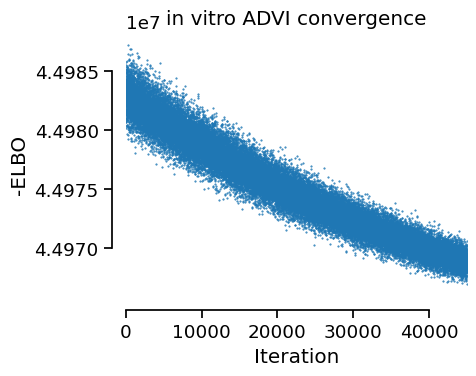

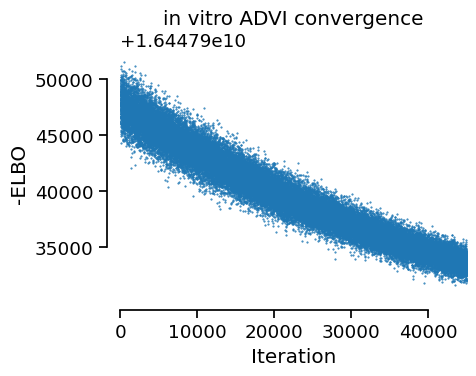

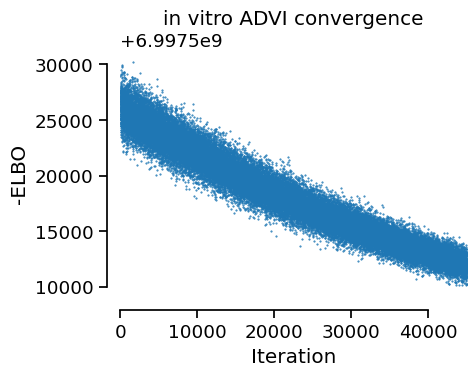

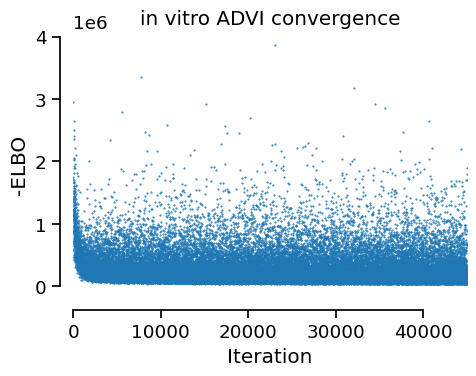

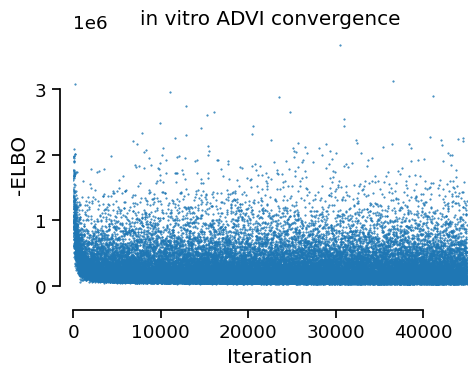

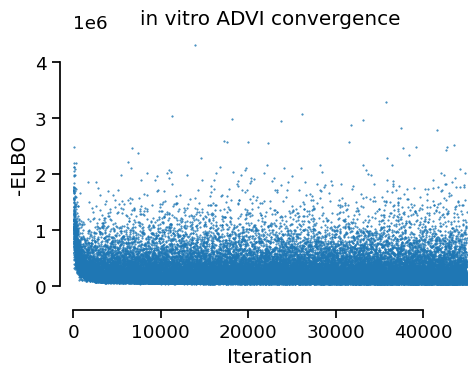

In [15]:
trace_all_v_1 = run_BayesInf_v(BIOMD64, data)
trace_all_v_2 = run_BayesInf_v(BIOMD64, data)
trace_all_v_3 = run_BayesInf_v(BIOMD64, data)
trace_all_e_1 = run_BayesInf_e(BIOMD64, data)
trace_all_e_2 = run_BayesInf_e(BIOMD64, data)
trace_all_e_3 = run_BayesInf_e(BIOMD64, data)

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 5.9002e+07


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1.3682e+07


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1.9789e+07


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 2.4837e+05


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 2.5583e+05


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 2.5783e+05


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 84,633


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 84,381


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 84,936


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 3.1506e+05


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 3.0949e+05


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 3.0751e+05


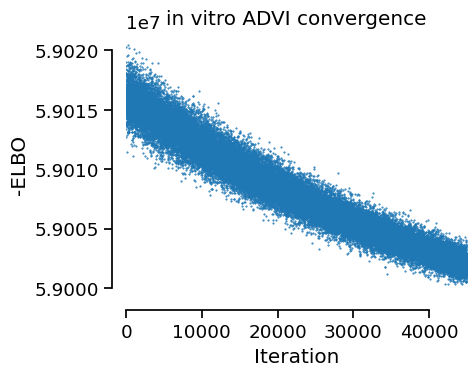

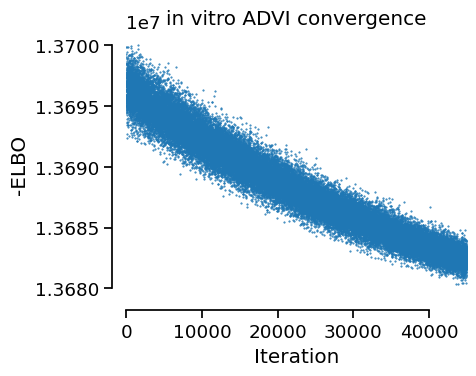

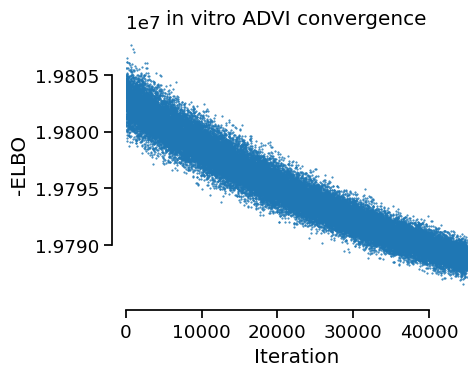

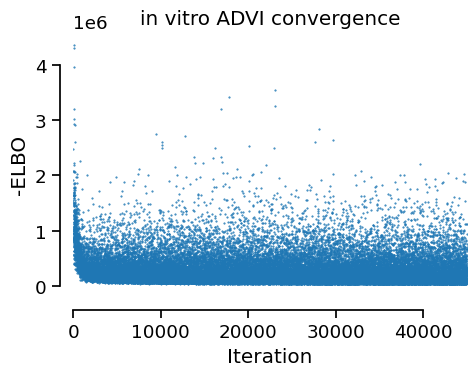

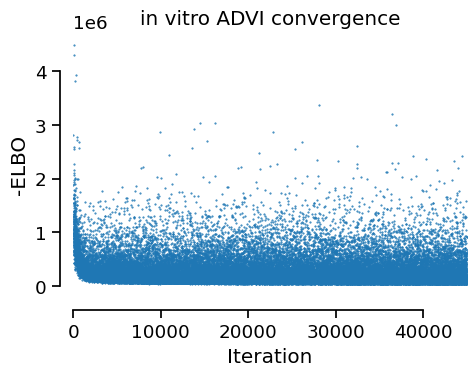

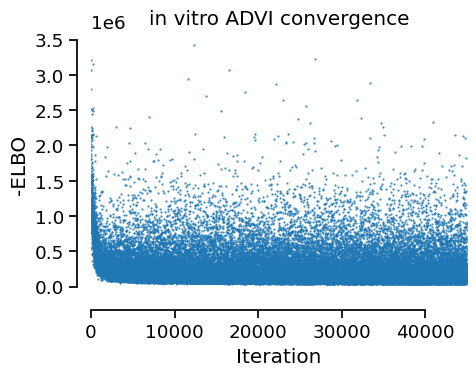

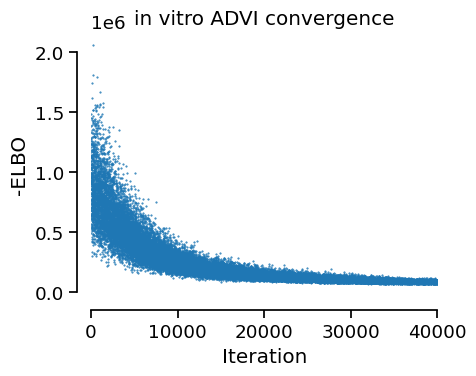

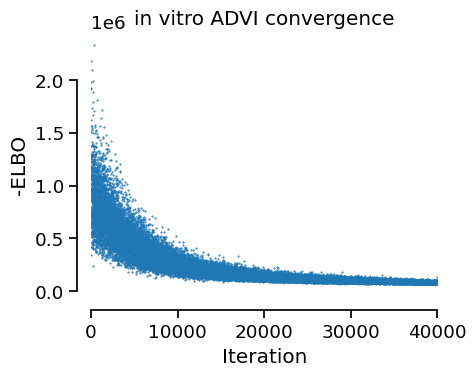

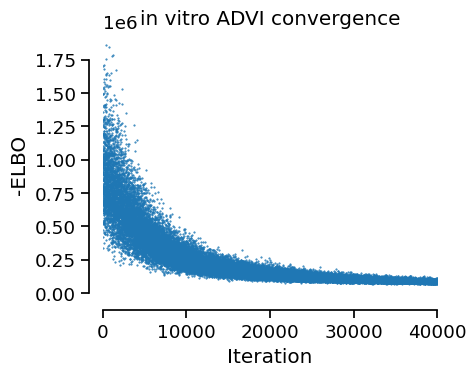

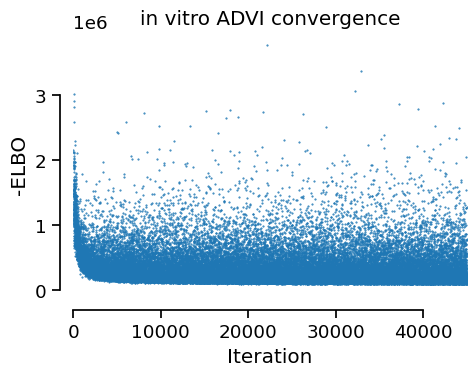

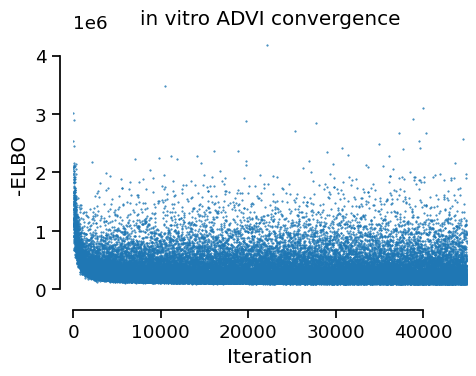

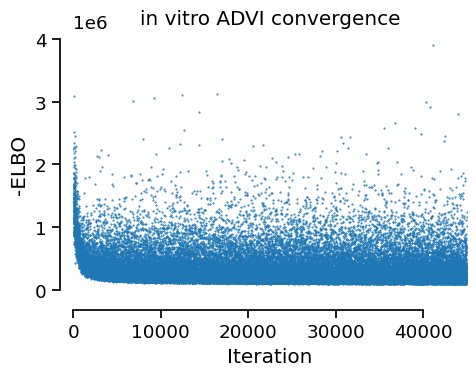

In [16]:
trace_v_1 = run_BayesInf_v(BIOMD64_v, crossSections[0])
trace_v_2 = run_BayesInf_v(BIOMD64_v, crossSections[0])
trace_v_3 = run_BayesInf_v(BIOMD64_v, crossSections[0])
trace_e_1 = run_BayesInf_e(BIOMD64_e, crossSections[1])
trace_e_2 = run_BayesInf_e(BIOMD64_e, crossSections[1])
trace_e_3 = run_BayesInf_e(BIOMD64_e, crossSections[1])
trace_x_1 = run_BayesInf_x(BIOMD64_x, crossSections[2])
trace_x_2 = run_BayesInf_x(BIOMD64_x, crossSections[2])
trace_x_3 = run_BayesInf_x(BIOMD64_x, crossSections[2])
trace_y_1 = run_BayesInf_y(BIOMD64_y, crossSections[3])
trace_y_2 = run_BayesInf_y(BIOMD64_y, crossSections[3])
trace_y_3 = run_BayesInf_y(BIOMD64_y, crossSections[3])


## Plotting traces

In [28]:
Ex_all_v_1 = (trace_all_v_1['posterior']['Ex']).to_numpy().squeeze()
Ex_all_v_2 = (trace_all_v_2['posterior']['Ex']).to_numpy().squeeze()
Ex_all_v_3 = (trace_all_v_3['posterior']['Ex']).to_numpy().squeeze()

Ex_all_e_1 = (trace_all_e_1['posterior']['Ex']).to_numpy().squeeze()
Ex_all_e_2 = (trace_all_e_2['posterior']['Ex']).to_numpy().squeeze()
Ex_all_e_3 = (trace_all_e_3['posterior']['Ex']).to_numpy().squeeze()

all_Ex_all_v = np.concatenate([Ex_all_v_1, Ex_all_v_2, Ex_all_v_3], axis=0)
all_Ex_all_e = np.concatenate([Ex_all_e_1, Ex_all_e_2, Ex_all_e_3], axis=0)

In [19]:
Ex_v_1 = (trace_v_1['posterior']['Ex']).to_numpy().squeeze()
Ex_v_2 = (trace_v_2['posterior']['Ex']).to_numpy().squeeze()
Ex_v_3 = (trace_v_3['posterior']['Ex']).to_numpy().squeeze()
Ex_e_1 = (trace_e_1['posterior']['Ex']).to_numpy().squeeze()
Ex_e_2 = (trace_e_2['posterior']['Ex']).to_numpy().squeeze()
Ex_e_3 = (trace_e_3['posterior']['Ex']).to_numpy().squeeze()
Ex_x_1 = (trace_x_1['posterior']['Ex']).to_numpy().squeeze()
Ex_x_2 = (trace_x_2['posterior']['Ex']).to_numpy().squeeze()
Ex_x_3 = (trace_x_3['posterior']['Ex']).to_numpy().squeeze()
Ex_y_1 = (trace_y_1['posterior']['Ex']).to_numpy().squeeze()
Ex_y_2 = (trace_y_2['posterior']['Ex']).to_numpy().squeeze()
Ex_y_3 = (trace_y_3['posterior']['Ex']).to_numpy().squeeze()

all_Exs = [Ex_v_1, Ex_v_2, Ex_v_3, Ex_e_1, Ex_e_2, Ex_e_3, Ex_x_1, Ex_x_2, Ex_x_3, Ex_y_1, Ex_y_2, Ex_y_3]

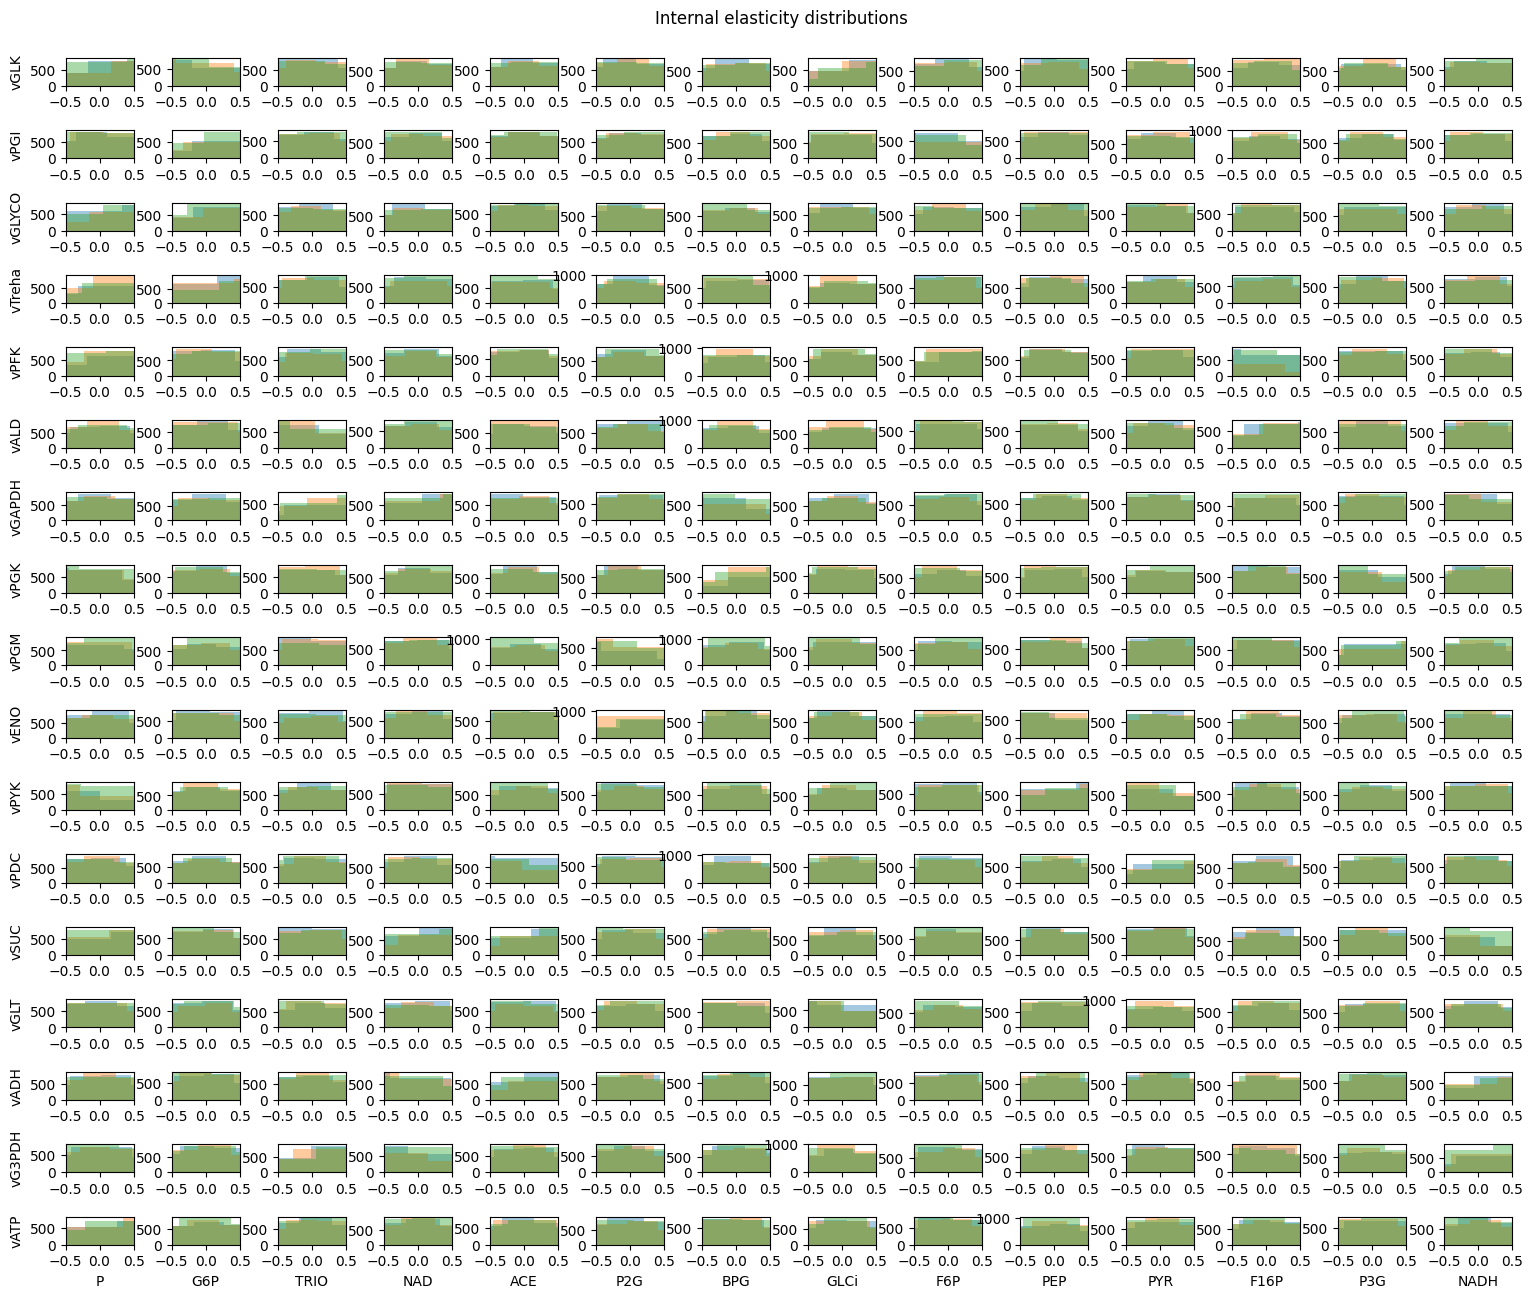

In [29]:
all_Ex_v = np.concatenate([Ex_v_1, Ex_v_2, Ex_v_3], axis=0)

# create a subplot that is (17,14)
fig, axs = plt.subplots(17,14, figsize=(15, 13)) 

fig.suptitle('Internal elasticity distributions\n')
fig.tight_layout()

for Ex_trace in [all_Ex_v, all_Ex_all_v, all_Ex_all_e]:
  Ex_trace = Ex_trace.transpose(1,2,0)
  for i in range(17):
    for ii in range(14):
      axs[i,ii].hist(Ex_trace[i,ii,:], alpha=0.4)
      axs[i,ii].set_xlim([-0.5,0.5])

      if ii == 0:
        axs[i,ii].set_ylabel(r.getReactionIds()[i])
      if i == 16: 
        axs[i,ii].set_xlabel(r.getFloatingSpeciesIds()[ii])

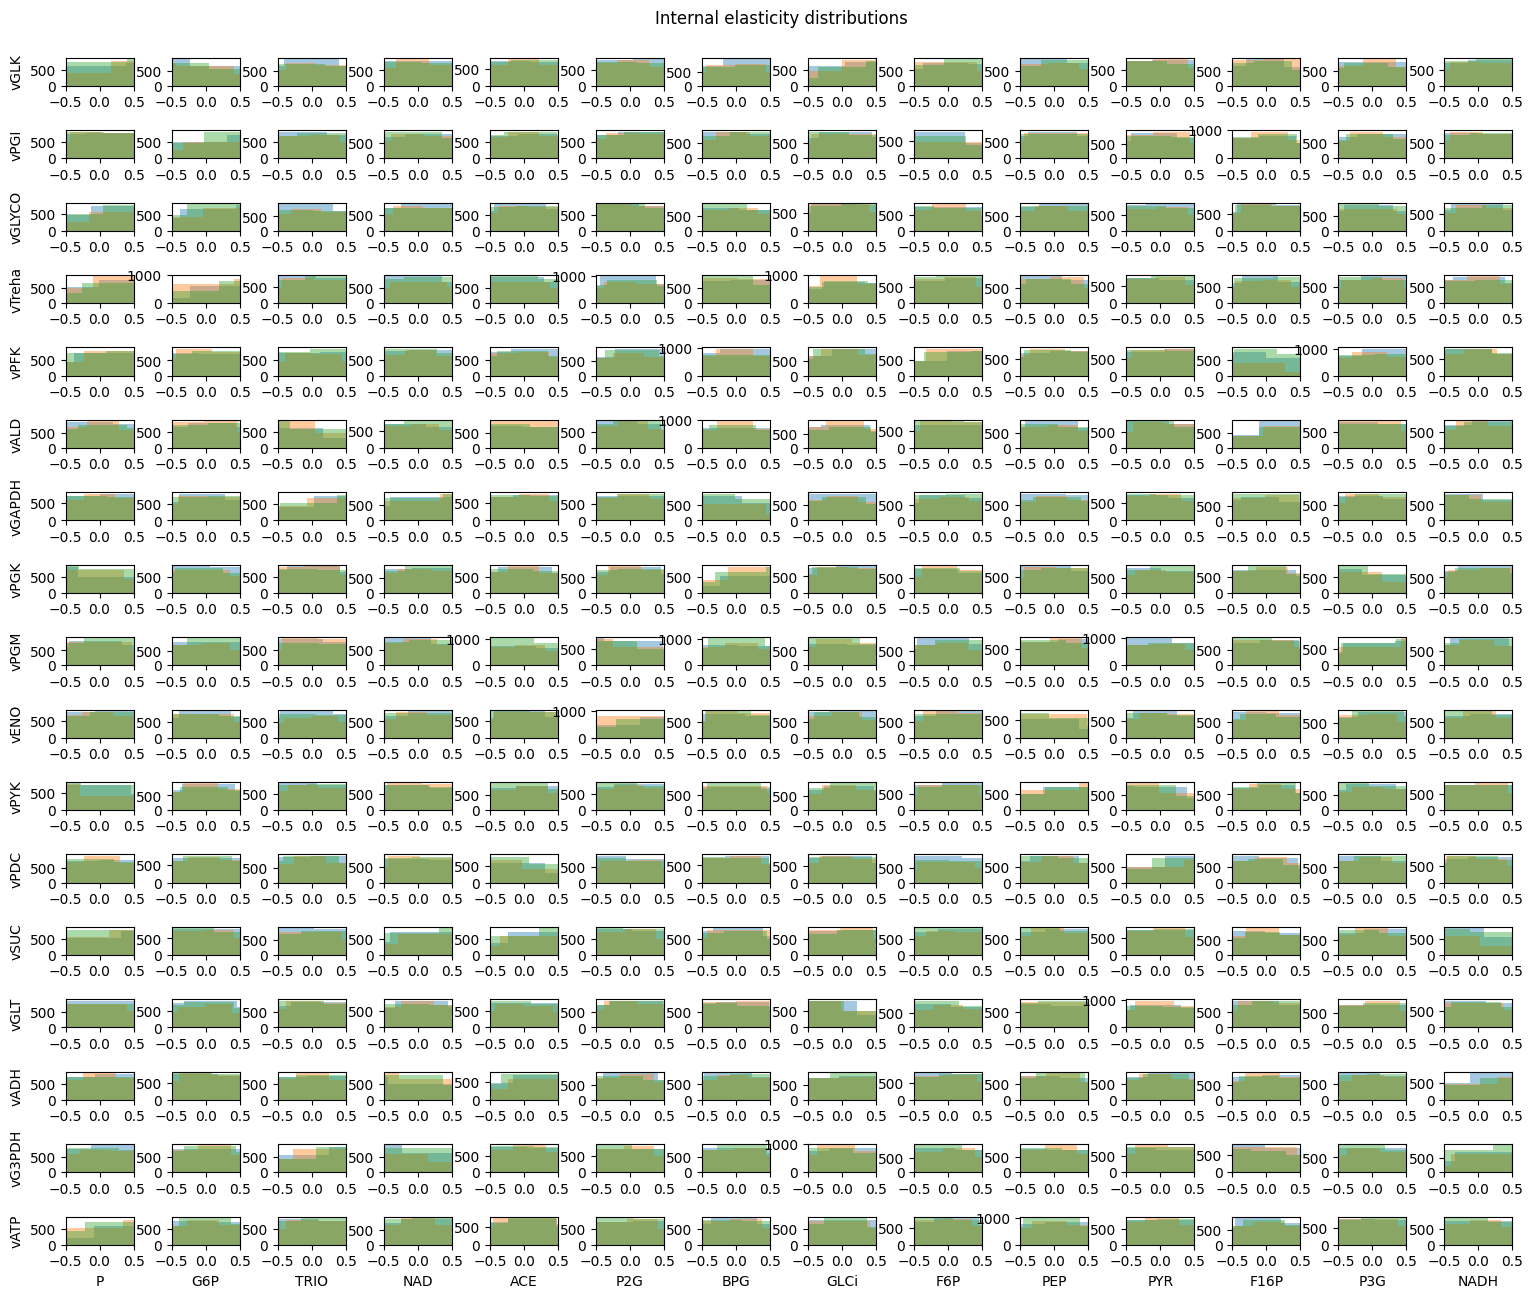

In [31]:
all_Ex_e = np.concatenate([Ex_e_1, Ex_e_2, Ex_e_3], axis=0)

# create a subplot that is (17,14)
fig, axs = plt.subplots(17,14, figsize=(15, 13)) 

fig.suptitle('Internal elasticity distributions\n')
fig.tight_layout()

for Ex_trace in [all_Ex_e, all_Ex_all_v, all_Ex_all_e]:
  Ex_trace = Ex_trace.transpose(1,2,0)
  for i in range(17):
    for ii in range(14):
      axs[i,ii].hist(Ex_trace[i,ii,:], alpha=0.4)
      axs[i,ii].set_xlim([-0.5,0.5])

      if ii == 0:
        axs[i,ii].set_ylabel(r.getReactionIds()[i])
      if i == 16: 
        axs[i,ii].set_xlabel(r.getFloatingSpeciesIds()[ii])

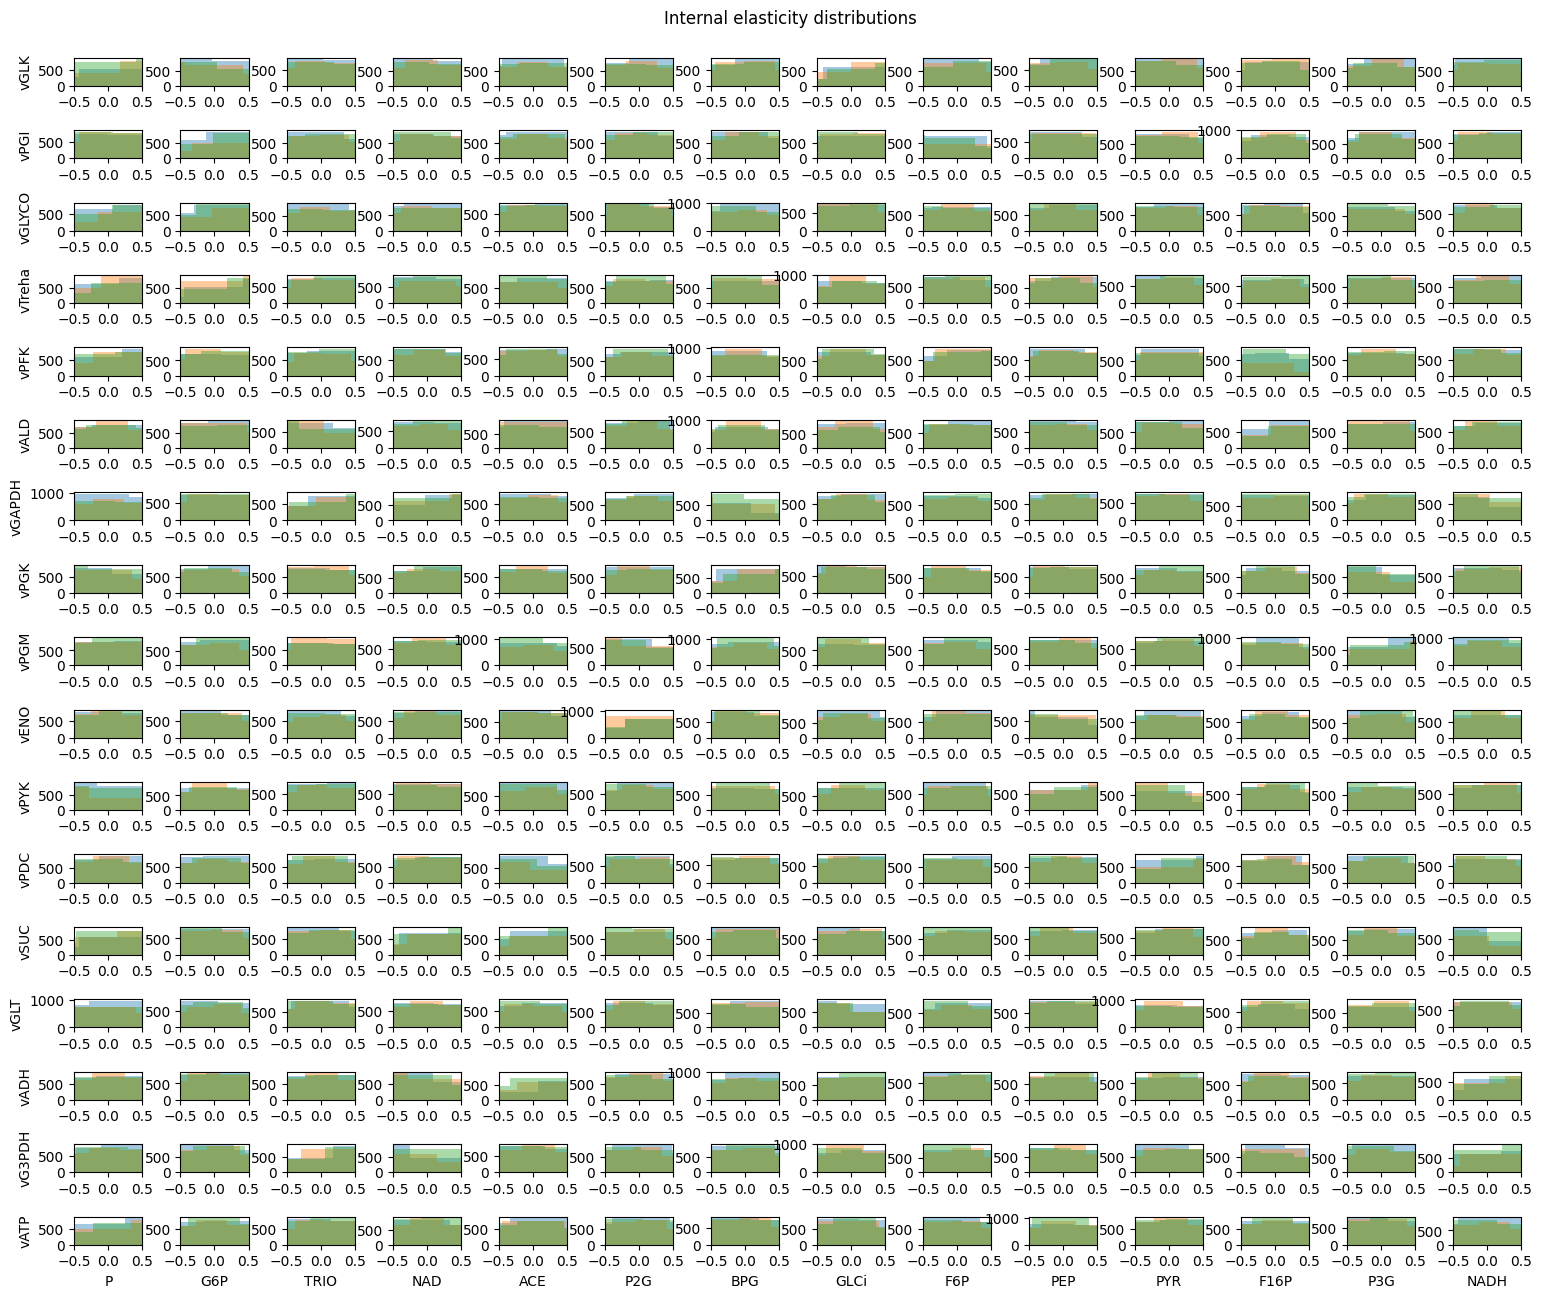

In [37]:
all_Ex_x = np.concatenate([Ex_x_1, Ex_x_2, Ex_x_3], axis=0)
# create a subplot that is (17,14)
fig, axs = plt.subplots(17,14, figsize=(15, 13)) 

fig.suptitle('Internal elasticity distributions\n')
fig.tight_layout()

for Ex_trace in [all_Ex_x, all_Ex_all_v, all_Ex_all_e]:
  Ex_trace = Ex_trace.transpose(1,2,0)
  for i in range(17):
    for ii in range(14):
      axs[i,ii].hist(Ex_trace[i,ii,:], alpha=0.4)
      axs[i,ii].set_xlim([-0.5,0.5])

      if ii == 0:
        axs[i,ii].set_ylabel(r.getReactionIds()[i])
      if i == 16: 
        axs[i,ii].set_xlabel(r.getFloatingSpeciesIds()[ii])

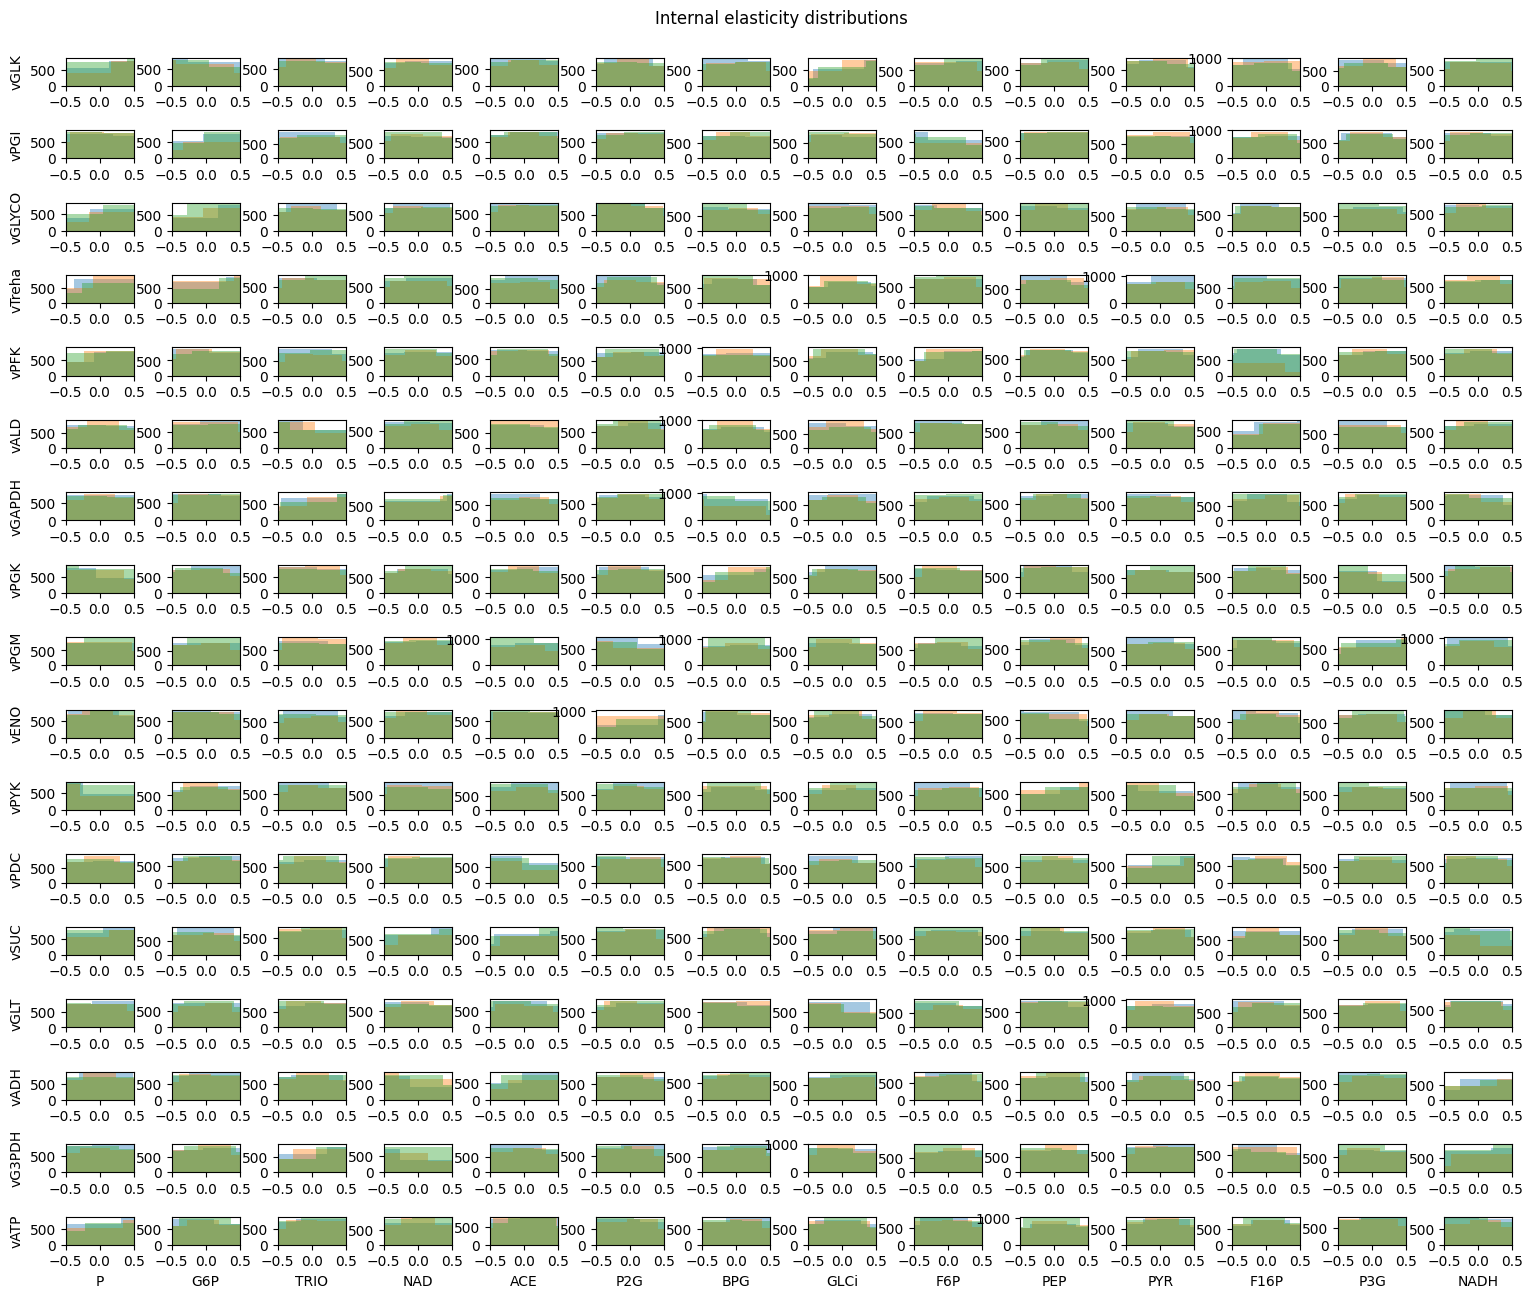

In [38]:
all_Ex_y = np.concatenate([Ex_y_1, Ex_y_2, Ex_y_3], axis=0)
# create a subplot that is (17,14)
fig, axs = plt.subplots(17,14, figsize=(15, 13)) 

fig.suptitle('Internal elasticity distributions\n')
fig.tight_layout()

for Ex_trace in [all_Ex_y, all_Ex_all_v, all_Ex_all_e]:
  Ex_trace = Ex_trace.transpose(1,2,0)
  for i in range(17):
    for ii in range(14):
      axs[i,ii].hist(Ex_trace[i,ii,:], alpha=0.4)
      axs[i,ii].set_xlim([-0.5,0.5])

      if ii == 0:
        axs[i,ii].set_ylabel(r.getReactionIds()[i])
      if i == 16: 
        axs[i,ii].set_xlabel(r.getFloatingSpeciesIds()[ii])

blue: fluxes  
orange: enzymes    
green: internal metabolites   
red: external metabolites   

## Plotting MCC and FCC comparisons

In [39]:
gtCCC = pd.DataFrame(r.getScaledConcentrationControlCoefficientMatrix(), index=r.getFloatingSpeciesIds(), columns=r.getReactionIds())
gtFCC = pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), index=r.getReactionIds(), columns=r.getReactionIds())

In [40]:
post_v_t_1 = (trace_v_1['posterior']['v_t']).to_numpy().squeeze().transpose(1, 2, 0)
post_v_t_2 = (trace_v_2['posterior']['v_t']).to_numpy().squeeze().transpose(1, 2, 0)
post_v_t_3 = (trace_v_3['posterior']['v_t']).to_numpy().squeeze().transpose(1, 2, 0)

post_v_t = np.median(np.concatenate([post_v_t_1, post_v_t_2, post_v_t_3], axis=2), axis=2)

In [41]:
post_e_t_1 = (trace_e_1['posterior']['e_t']).to_numpy().squeeze().transpose(1, 2, 0)
post_e_t_2 = (trace_e_2['posterior']['e_t']).to_numpy().squeeze().transpose(1, 2, 0)
post_e_t_3 = (trace_e_3['posterior']['e_t']).to_numpy().squeeze().transpose(1, 2, 0)

post_e_t = np.median(np.concatenate([post_e_t_1, post_e_t_2, post_e_t_3], axis=2), axis=2)

In [45]:
def estimate_CCs(BMCA_obj, Ex, vn=None, en=None):
    BMCA_obj.vn[BMCA_obj.vn == 0] = 1e-6
    
    if vn is not None:
        a = np.diag(BMCA_obj.en.values / post_v_t.T)
    elif en is not None: 
        a = np.diag(post_e_t.T/ BMCA_obj.vn.values)
    else:
        a = np.diag(BMCA_obj.en.values / BMCA_obj.vn.values)
    a = np.diag(a)
    a = a[np.newaxis,:].repeat(Ex.shape[0], axis=0)

    Ex_ss = a @ Ex
    As = BMCA_obj.N @ np.diag(BMCA_obj.v_star) @ Ex_ss
    bs = BMCA_obj.N @ np.diag(BMCA_obj.v_star)
    bs = bs[np.newaxis, :].repeat(Ex.shape[0], axis=0)
    
    As = at.as_tensor_variable(As)
    bs = at.as_tensor_variable(bs)

    def solve_aesara(A, b):
        rsolve_op = LeastSquaresSolve()
        return rsolve_op(A, b).squeeze()

    CCC, _ = aesara.scan(lambda A, b: solve_aesara(A, b),
                        sequences=[As, bs], strict=True)

    identity = np.eye(len(BMCA_obj.N.T))
    identity = identity[np.newaxis,:].repeat(Ex.shape[0], axis=0)
    
    FCC = (Ex_ss @ CCC.eval()) + identity
    
    return CCC.eval(), FCC


We are focusing on the ADH reaction since it is the one that leads to our terminal metabolite ethanol.

In [46]:
ADH_idx = r.getReactionIds().index('vADH')
ADH_FCCs = []

def append_FCC_df(postFCC, label):
    df = pd.DataFrame(postFCC[:,ADH_idx,:], columns=r.getReactionIds())
    df['label']=[label]*len(df)
    ADH_FCCs.append(df)

postCCC, postFCC = estimate_CCs(BIOMD64_v, all_Ex_v, vn=post_v_t)
append_FCC_df(postFCC, 'fluxes')
postCCC, postFCC = estimate_CCs(BIOMD64_e, all_Ex_e, en=post_e_t)
append_FCC_df(postFCC, 'enzymes')
postCCC, postFCC = estimate_CCs(BIOMD64_x, all_Ex_x)
append_FCC_df(postFCC, 'internal')
postCCC, postFCC = estimate_CCs(BIOMD64_y, all_Ex_y)
append_FCC_df(postFCC, 'external')

postCCC, postFCC = estimate_CCs(BIOMD64_x, all_Ex_all_v)
append_FCC_df(postFCC, 'none_v')
postCCC, postFCC = estimate_CCs(BIOMD64_y, all_Ex_all_e)
append_FCC_df(postFCC, 'none_e')

ADH_FCCs = pd.concat(ADH_FCCs)

In [47]:
ADH_sns_df = pd.DataFrame(ADH_FCCs.loc[:, ADH_FCCs.columns != 'label'].unstack())
ADH_sns_df['label'] = list(ADH_FCCs['label']) * 17

In [48]:
ADH_sns_df = ADH_sns_df.reset_index()
ADH_sns_df = ADH_sns_df.drop('level_1', axis=1) # could also probably drop 'index'?
ADH_sns_df.columns = ['reaction', 'value', 'label']
ADH_sns_df.head()

,reaction,value,label
0,vGLK,-0.771011,fluxes
1,vGLK,-0.269597,fluxes
2,vGLK,0.054465,fluxes
3,vGLK,-0.198033,fluxes
4,vGLK,0.104386,fluxes


Text(0.5, 1.0, 'ADVI predictions for ADH FCCs based on datatype omitted—100% omission')

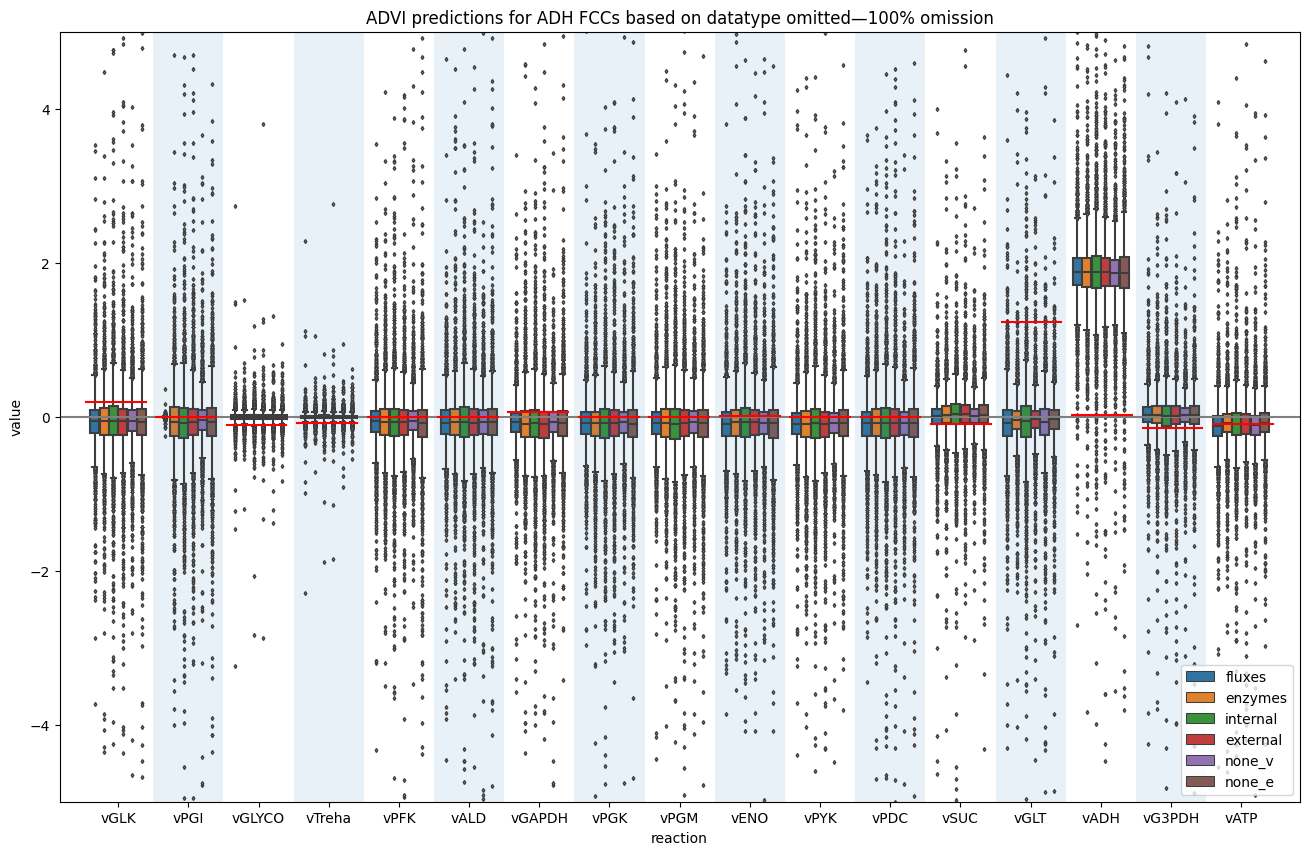

In [49]:
fig = plt.figure(figsize=(16, 10))

# change the outlier markers to smaller pinpoints
flierprops = dict(markerfacecolor='0.75', markersize=2,
              linestyle='none')
sns.boxplot(data=ADH_sns_df, x="reaction", y="value", hue='label', flierprops=flierprops) # , gap=.1

# add in ground truth lines
for i,val in enumerate(gtFCC.loc['vADH']): # .sort_index()
        plt.axhline(y = val, xmin = (0.021 + 0.0027*i) + (i*0.92)/17, xmax = (0.021 + 0.0027*i) + (i*0.92 + 0.82)/17, c='red', zorder=100)

# alternate color each group of reactions so it is easier to see
for i in range(8):
        plt.axvspan(2*i + 0.5, 2*i + 1.5, alpha=0.1)

plt.axhline(0, c='gray')
plt.ylim((-5,5))
plt.legend(loc='lower right')

plt.title('ADVI predictions for ADH FCCs based on datatype omitted—100% omission')

## Trehalose FCCs

In [52]:
TRE_idx = r.getReactionIds().index('vTreha')
TRE_FCCs = []

def append_FCC_df(postFCC, label):
    df = pd.DataFrame(postFCC[:,TRE_idx,:], columns=r.getReactionIds())
    df['label']=[label]*len(df)
    TRE_FCCs.append(df)

postCCC, postFCC = estimate_CCs(BIOMD64_v, all_Ex_v, vn=post_v_t)
append_FCC_df(postFCC, 'fluxes')
postCCC, postFCC = estimate_CCs(BIOMD64_e, all_Ex_e, en=post_e_t)
append_FCC_df(postFCC, 'enzymes')
postCCC, postFCC = estimate_CCs(BIOMD64_x, all_Ex_x)
append_FCC_df(postFCC, 'internal')
postCCC, postFCC = estimate_CCs(BIOMD64_y, all_Ex_y)
append_FCC_df(postFCC, 'external')

postCCC, postFCC = estimate_CCs(BIOMD64_x, all_Ex_all_v)
append_FCC_df(postFCC, 'none_v')
postCCC, postFCC = estimate_CCs(BIOMD64_y, all_Ex_all_e)
append_FCC_df(postFCC, 'none_e')

TRE_FCCs = pd.concat(TRE_FCCs)

In [53]:
TRE_sns_df = pd.DataFrame(TRE_FCCs.loc[:, TRE_FCCs.columns != 'label'].unstack())
TRE_sns_df['label'] = list(TRE_FCCs['label']) * 17

In [54]:
TRE_sns_df = TRE_sns_df.reset_index()
TRE_sns_df = TRE_sns_df.drop('level_1', axis=1) # could also probably drop 'index'?
TRE_sns_df.columns = ['reaction', 'value', 'label']
TRE_sns_df.head()

,reaction,value,label
0,vGLK,1.459229,fluxes
1,vGLK,-1.169625,fluxes
2,vGLK,0.316503,fluxes
3,vGLK,0.191952,fluxes
4,vGLK,0.102377,fluxes


Text(0.5, 1.0, 'ADVI predictions for TRE FCCs based on datatype omitted—100% omission')

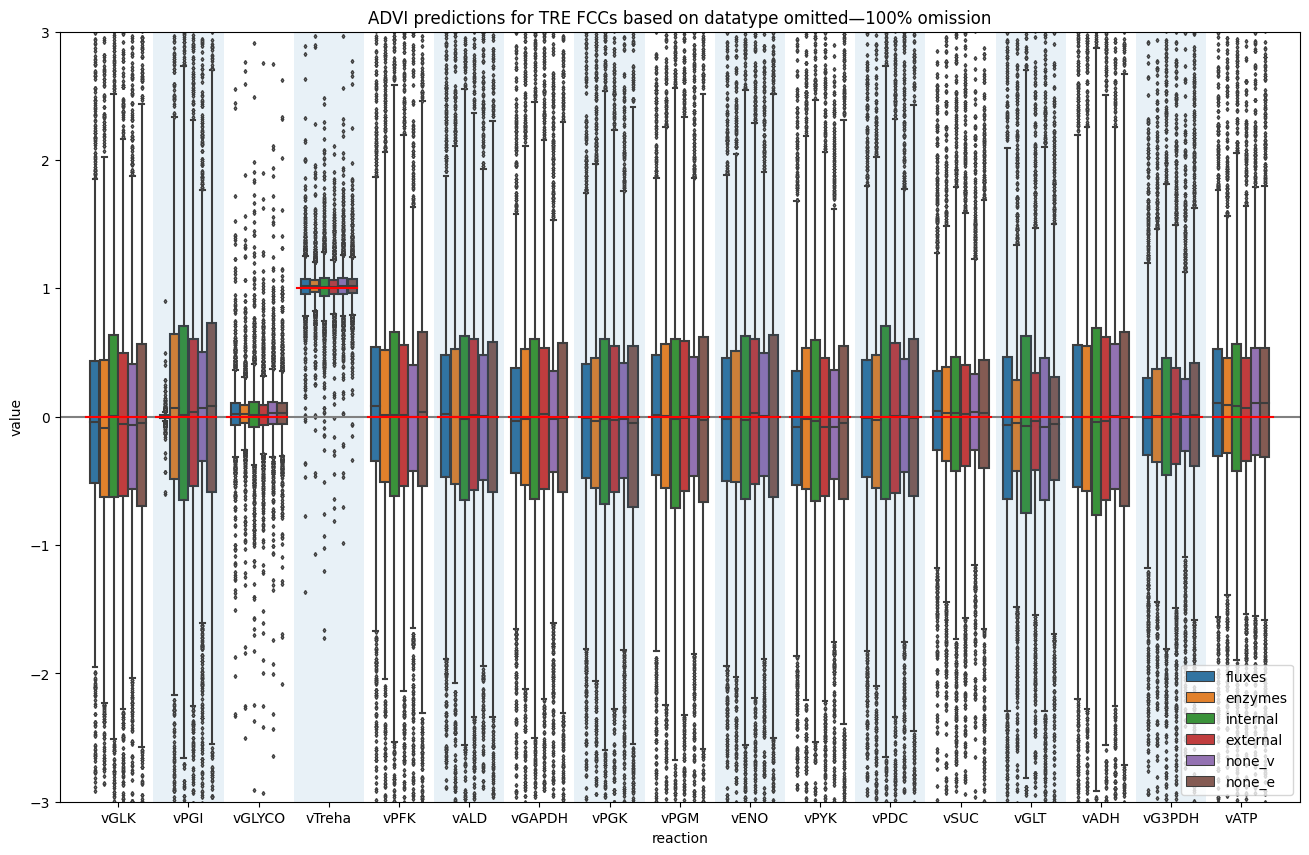

In [57]:
fig = plt.figure(figsize=(16, 10))

# change the outlier markers to smaller pinpoints
flierprops = dict(markerfacecolor='0.75', markersize=2,
              linestyle='none')
sns.boxplot(data=TRE_sns_df, x="reaction", y="value", hue='label', flierprops=flierprops) # , gap=.1

# add in ground truth lines
for i,val in enumerate(gtFCC.loc['vTreha']): # .sort_index()
        plt.axhline(y = val, xmin = (0.021 + 0.0027*i) + (i*0.92)/17, xmax = (0.021 + 0.0027*i) + (i*0.92 + 0.82)/17, c='red', zorder=100)

# alternate color each group of reactions so it is easier to see
for i in range(8):
        plt.axvspan(2*i + 0.5, 2*i + 1.5, alpha=0.1)

plt.axhline(0, c='gray')
plt.ylim((-3,3))
plt.legend(loc='lower right')

plt.title('ADVI predictions for TRE FCCs based on datatype omitted—100% omission')